In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import jax
import numpy as np
plt.style.use('science')

In [2]:
import glob
import pandas as pd

path = 'data_completa11'
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = [pd.read_csv(file) for file in csv_files]

In [7]:
from utils import pre_process

In [4]:
df_preprocessed = [pre_process(df) for df in df_list]

In [5]:
df_preprocessed[0].head()

,Estacion,E,N,pm25,pm10,no2,temp,velv,hrel
date_time,,,,,,,,,
2010-01-01 00:00:00,Independencia,346488,6300681,7.0,16.0,12.0,16.9500,1.085310,60.2500
2010-01-01 01:00:00,Independencia,346488,6300681,8.0,14.0,12.0,16.1917,1.108330,62.6666
2010-01-01 02:00:00,Independencia,346488,6300681,10.0,18.0,12.0,15.2917,0.924998,65.8333
2010-01-01 03:00:00,Independencia,346488,6300681,9.0,17.0,12.0,14.7917,0.858333,67.5000
2010-01-01 04:00:00,Independencia,346488,6300681,11.0,23.0,11.0,14.2083,0.666665,70.0833


In [6]:
df_group=pd.concat(df_preprocessed)

In [7]:
df_group['Estacion'] = df_group['Estacion'].astype('category')    

# Model Training

In [9]:
from utils import train_test_split, create_batch_multistep

In [10]:
X_train_datasets=list()
y_train_datasets=list()
X_test_datasets=list()
y_test_datasets=list()
future=1
past=24
dataset_names=list()
for item_id, gdf in df_group.groupby('Estacion'):
    print(f"Processing station: {item_id}")
    gdf = gdf.drop(columns=['Estacion'])
    gdf = gdf.sort_index()
    feature_keys = ['pm25','pm10','no2','temp','velv','hrel']
    # Split data into training and validation sets
    train_data, val_data = train_test_split(gdf, 0.8, feature_keys)
    train_multi_feature=list()
    test_multi_feature=list()
    for feature in feature_keys:
    # Create batches for training and validation
        X_train, y_train = create_batch_multistep(train_data, lag=past, future=future,feature=feature)
        X_val, y_val = create_batch_multistep(val_data, lag=past, future=future,feature=feature)
        train_multi_feature.append(X_train)
        test_multi_feature.append(X_val)
        if feature=='pm25':
            y_train_datasets.append(y_train)
            y_test_datasets.append(y_val)
    X_train_datasets.append(np.stack(train_multi_feature,axis=-1))
    X_test_datasets.append(np.stack(test_multi_feature,axis=-1))
    dataset_names.append(item_id)
    print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")
X_train_datasets=np.stack(X_train_datasets,axis=0)
X_train_datasets=X_train_datasets.swapaxes(-1,-2)
y_train_datasets=np.stack(y_train_datasets,axis=0)
X_test_datasets=np.stack(X_test_datasets,axis=0)
X_test_datasets=X_test_datasets.swapaxes(-1,-2)
y_test_datasets=np.stack(y_test_datasets,axis=0)

Processing station: Cerrillos
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: CerroNavia
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: ElBosque
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Independencia
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: LaFlorida
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: LasCondes
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: ParqueOhiggins
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Pudahuel
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: PuenteAlto
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Quilicura
Train shape: (42042, 24), Validation shape: (10493, 24)
Processing station: Talagante
Train shape: (42042, 24), Validation shape: (10493, 24)


In [11]:
X_test_datasets.shape,y_test_datasets.shape

((11, 10493, 6, 24), (11, 10493, 1))

In [12]:
from utils import get_dataloader

In [15]:
import optax
from flax import linen as nn
from functools import partial
import distrax
import jax.numpy as jnp

class LSTM(nn.Module):

    @nn.remat
    @nn.compact
    def __call__(self, X_batch):
        carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(X_batch)
        #carry,x=nn.RNN(nn.LSTMCell(32),return_carry=True)(x)
        x=nn.Dense(future)(x)
        return x[:,-1,:]

def site_log_likelihood(params, x, y):
    preds = jax.vmap(model.apply, (0, 0))(params, jnp.array(x,dtype=jnp.float32))
    return -1.0*jnp.mean(distrax.Independent(distrax.Normal(preds,1.0)).log_prob(jnp.array(y,dtype=jnp.float32)),axis=1)

def log_likelihood(params, X, y_data):
    log_likelihoods = site_log_likelihood(params, X, y_data)
    return jnp.mean(log_likelihoods)


grad_log_post=jax.jit(jax.grad(log_likelihood))

@partial(jax.jit, static_argnums=(3,4))
def sgld_kernel_momemtum(key, params, momemtum,grad_log_post, dt, X, y_data):
    gamma,eps=0.9,1e-6
    key, subkey = jax.random.split(key, 2)
    grads = grad_log_post(params, X, y_data)
    squared_grads=jax.tree.map(lambda g: jnp.square(g),grads)
    momemtum=jax.tree.map(lambda m,s : gamma*m+(1-gamma)*s,momemtum,squared_grads)
    noise=jax.tree.map(lambda p: jax.random.normal(key=subkey,shape=p.shape), params)
    params=jax.tree.map(lambda p, g,m,n: p-0.5*dt*g/(m+eps)+jnp.sqrt(dt)*n, params, grads,momemtum,noise)
    return key, params,momemtum

def sgld(key,log_post, grad_log_post, num_samples,
                             dt, x_0,X_train_datasets,y_train_datasets,batch_size,
                             test_data=None):
    samples = list()
    loss=list()
    param = x_0
    key_data, key_model = jax.random.split(key, 2)
    momemtum=jax.tree.map(lambda p:jnp.zeros_like(p),param)
    key_data_batch=jax.random.split(key_data, num_samples)
    for i in range(num_samples):
        train_data=get_dataloader(X_train_datasets,y_train_datasets,batch_size,key_data_batch[i],axis=1)
        for _,(X_batch, y_batch) in enumerate(train_data):
            key_model,param,momemtum = sgld_kernel_momemtum(key_model, param,momemtum, grad_log_post, dt, X_batch, y_batch)
        loss.append(site_log_likelihood(param,X_batch,y_batch))
        samples.append(param)
        if (i%(num_samples//10)==0):
            print('iteration {0}, loss {1:.2f}'.format(i,loss[-1].mean()))
    loss=np.stack(loss,axis=1)
    return samples,loss


In [16]:
key=jax.random.PRNGKey(0)
key_model,key_data=jax.random.split(key,2)
batch_size=256

In [17]:
model=LSTM()
n_groups=X_train_datasets.shape[0]
n_features=len(feature_keys)
inputs = jax.random.randint(key,(batch_size,n_features,past),0, 10,).astype(jnp.float32)
key_tasks=jax.random.split(key_model,n_groups)
params_tasks = jax.vmap(model.init, (0, None))(key_tasks, inputs)

In [18]:
dt=1e-5
samples,loss=sgld(key_data,log_likelihood, grad_log_post, 100,
                             dt, params_tasks,X_train_datasets,y_train_datasets,
                             batch_size,test_data=None)

IndexError: tuple index out of range

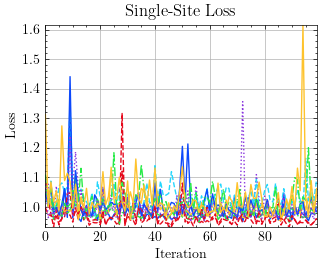

In [22]:
pparam = dict(xlabel="Iteration", ylabel=r"Loss")
with plt.style.context(["science","high-vis"]):
    #plt.Figure(figsize=(10, 16))
    n_groups = loss.shape[0]
    dataset_names = dataset_names[:n_groups]  # Ensure we only use names for the groups we have data for
    fig, ax = plt.subplots()
    for i in range(n_groups):
        ax.plot(loss[i,:,0], label=f'Station {dataset_names[i]}')
    ax.autoscale(tight=True)
    ax.set(**pparam)
    #plt.legend()
    #ax.xlabel('Iteration')
    #ax.ylabel('Loss')
    plt.title('Single-Site Loss')
    ax.grid()
plt.grid(True)
plt.savefig('single_site_loss.pdf', bbox_inches='tight',dpi=300)
plt.show()

In [23]:
preds = jax.vmap(model.apply, (0, 0))(params_tasks, jnp.array(X_test_datasets[:,0:256,:,:]))

In [48]:
import pickle

with open('sgld.samples', 'wb') as samples_file:
    pickle.dump(samples, samples_file)

# MCMC Model Diagnostics



In [49]:
with open('sgld.samples', 'rb') as samples_file:
    samples = pickle.load(samples_file)

In [24]:
reshaper = lambda s : jax.tree.map(lambda p : p.reshape((n_groups,-1)),s)

flat_params=list()
for s in samples:
    flat_sample=reshaper(s)['params']
    flat_sample=(jax.tree_util.tree_flatten(flat_sample)[0])
    flat_sample=jnp.concatenate(flat_sample,axis=-1)
    flat_params.append(flat_sample)
flat_params=jnp.stack(flat_params,axis=1)

In [25]:
import tensorflow_probability as tfp


In [26]:
import tensorflow_probability as tfp

ess_list=list()

for g in flat_params:
    ess = tfp.mcmc.effective_sample_size(g, filter_beyond_positive_pairs=True)
    ess_list.append(ess.numpy())
ess_list=jnp.stack(ess_list)



Failed to import TensorFlow. Please note that TensorFlow is not installed by default when you install TensorFlow Probability. This is so that users can decide whether to install the GPU-enabled TensorFlow package. To use TensorFlow Probability, please install the most recent version of TensorFlow, by following instructions at https://tensorflow.org/install.




ModuleNotFoundError: No module named 'tensorflow'

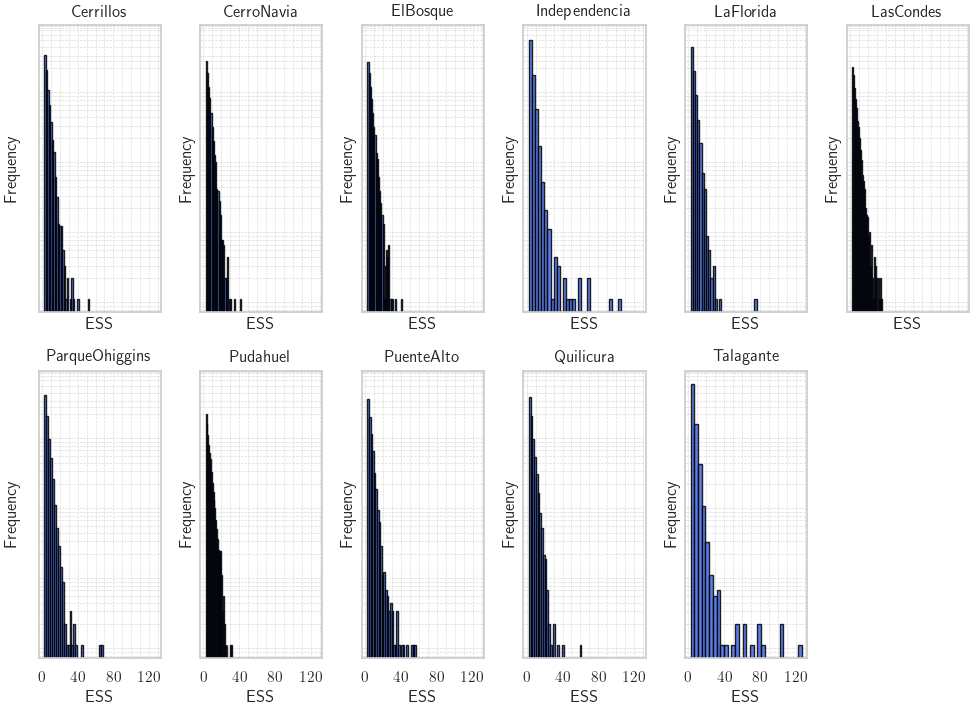

In [ ]:
import matplotlib.ticker as mticker

fig, axes = plt.subplots(2, 6, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for i, ess in enumerate(ess_list):
    axes[i].hist(ess, bins=30, color='royalblue', alpha=0.85, edgecolor='black')
    axes[i].set_title(dataset_names[i], fontsize=12)
    axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    axes[i].set_xlabel("ESS", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)
    axes[i].xaxis.set_major_locator(mticker.MaxNLocator(4))
    axes[i].yaxis.set_major_locator(mticker.MaxNLocator(4))

# Hide unused subplots if any
for j in range(i+1, len(axes)):
    axes[j].axis('off')

#fig.suptitle("Effective Sample Size (ESS) per Station", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('single_site_ess.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Posterior Predictive

In [27]:
X_test=X_test_datasets
params=samples[-1]
preds=jax.vmap(model.apply, (0, 0))(params, X_test)

In [28]:
from sklearn import metrics
r_metric=list()
rmse_metric=list()
mae_metric=list()
for i in range(n_groups):
    r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
    rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:])
    mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
    r_metric.append(r_squared)
    rmse_metric.append(rmse)
    mae_metric.append(mae)
    print('task : {0}, RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse,mae,r_squared))
print('-------------------------------------------------------')
print('RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(np.mean(rmse_metric),np.mean(mae_metric),np.mean(r_metric)))

task : Cerrillos, RMSE : 0.20, MAE :0.29, R2 :0.82
task : CerroNavia, RMSE : 0.09, MAE :0.18, R2 :0.90
task : ElBosque, RMSE : 0.18, MAE :0.26, R2 :0.79
task : Independencia, RMSE : 0.21, MAE :0.31, R2 :0.84
task : LaFlorida, RMSE : 0.19, MAE :0.28, R2 :0.83
task : LasCondes, RMSE : 0.26, MAE :0.35, R2 :0.76
task : ParqueOhiggins, RMSE : 0.25, MAE :0.32, R2 :0.72
task : Pudahuel, RMSE : 0.15, MAE :0.22, R2 :0.83
task : PuenteAlto, RMSE : 0.20, MAE :0.29, R2 :0.73
task : Quilicura, RMSE : 0.21, MAE :0.28, R2 :0.80
task : Talagante, RMSE : 0.33, MAE :0.35, R2 :0.57
-------------------------------------------------------
RMSE : 0.21, MAE :0.28, R2 :0.78


In [29]:
ensemble_pred=list()
X_test=X_test_datasets
r_metric={i: [] for i in range(n_groups)}
rmse_metric={i: [] for i in range(n_groups)}
mae_metric={i: [] for i in range(n_groups)}
for j in range(len(samples)):
    params=samples[j]
    preds=jax.vmap(model.apply, (0, 0))(params, X_test)
    ensemble_pred.append(preds)
    for i in range(n_groups):
        r_squared=metrics.r2_score(preds[i,:,:],y_test_datasets[i,:,:])
        rmse=metrics.mean_squared_error(preds[i,:,:],y_test_datasets[i,:,:])
        mae=metrics.mean_absolute_error(preds[i,:,:],y_test_datasets[i,:,:])
        r_metric[i].append(r_squared)
        rmse_metric[i].append(rmse)
        mae_metric[i].append(mae)

In [30]:
ensemble_pred=np.stack(ensemble_pred,axis=-1)

In [31]:
mean_pred=np.mean(ensemble_pred,axis=-1)
std_pred=np.std(ensemble_pred,axis=-1)

In [32]:
for i in range(n_groups):
    r_squared=np.mean(r_metric[i]),2*np.std(r_metric[i])
    rmse=np.mean(rmse_metric[i]),2*np.std(rmse_metric[i])
    mae=np.mean(mae_metric[i]),2*np.std(mae_metric[i])
    print('task : {0}, Mean RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse[0],mae[0],r_squared[0]))
    print('task : {0}, Error RMSE : {1:1.2f}, MAE :{2:1.2f}, R2 :{3:1.2f}'.format(dataset_names[i],rmse[1],mae[1],r_squared[1]))
    print('-------------------------------------------------------')
mean_mae,error_mae=np.concatenate([mae_metric[i] for i in range(n_groups)]).mean(),2*np.concatenate([mae_metric[i] for i in range(n_groups)]).std()
mean_r,error_r=np.concatenate([r_metric[i] for i in range(n_groups)]).mean(),2*np.concatenate([r_metric[i] for i in range(n_groups)]).std()
mean_rmse,error_rmse=np.concatenate([rmse_metric[i] for i in range(n_groups)]).mean(),2*np.concatenate([rmse_metric[i] for i in range(n_groups)]).std()
print('Mean RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(mean_rmse,mean_mae,mean_r))
print('Eror RMSE : {0:1.2f}, MAE :{1:1.2f}, R2 :{2:1.2f}'.format(error_rmse,error_mae,error_r))

task : Cerrillos, Mean RMSE : 0.23, MAE :0.31, R2 :0.78
task : Cerrillos, Error RMSE : 0.06, MAE :0.04, R2 :0.13
-------------------------------------------------------
task : CerroNavia, Mean RMSE : 0.10, MAE :0.20, R2 :0.87
task : CerroNavia, Error RMSE : 0.05, MAE :0.04, R2 :0.10
-------------------------------------------------------
task : ElBosque, Mean RMSE : 0.20, MAE :0.28, R2 :0.76
task : ElBosque, Error RMSE : 0.08, MAE :0.05, R2 :0.20
-------------------------------------------------------
task : Independencia, Mean RMSE : 0.25, MAE :0.34, R2 :0.77
task : Independencia, Error RMSE : 0.12, MAE :0.06, R2 :0.22
-------------------------------------------------------
task : LaFlorida, Mean RMSE : 0.21, MAE :0.30, R2 :0.80
task : LaFlorida, Error RMSE : 0.07, MAE :0.04, R2 :0.12
-------------------------------------------------------
task : LasCondes, Mean RMSE : 0.28, MAE :0.36, R2 :0.71
task : LasCondes, Error RMSE : 0.10, MAE :0.05, R2 :0.26
----------------------------------

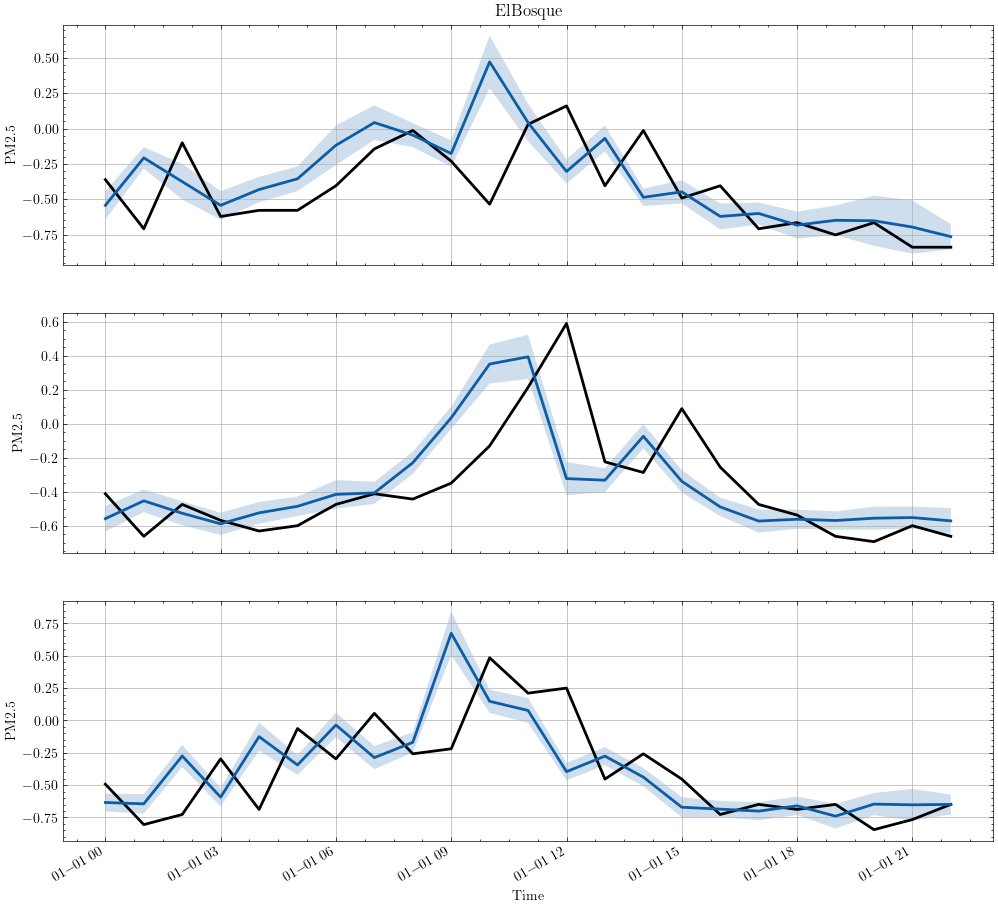

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(12, 12))

future_pred=0
names=np.ravel(gdf.index[0:23].to_frame().values)
ax1.plot(names,y_test_datasets[0,:23,future_pred], linewidth=2,color="black")
ax1.plot(names,mean_pred[0,2:25,future_pred], linewidth=2)
ax1.fill_between(names,np.ravel(mean_pred[0,2:25,future_pred]-std_pred[0,2:25,future_pred]),np.ravel(mean_pred[0,2:25,future_pred]+std_pred[0,2:25,future_pred]),alpha=0.2)
ax1.set_xlabel('Time')
ax1.set_ylabel('PM2.5')
#ax1.legend(dataset_names[0], loc="upper left", fontsize="xx-large")
ax1.grid(True)

ax2.plot(names,y_test_datasets[1,:23,future_pred], linewidth=2,color="black")
ax2.plot(names,mean_pred[1,2:25,future_pred], linewidth=2)
ax2.fill_between(names,np.ravel(mean_pred[1,2:25,future_pred]-std_pred[1,2:25,future_pred]),np.ravel(mean_pred[1,2:25,future_pred]+std_pred[1,2:25,future_pred]),alpha=0.2)
ax2.set_xlabel('Time')
ax2.set_ylabel('PM2.5')
ax1.set_title(dataset_names[1])
ax2.grid(True)

ax3.plot(names,y_test_datasets[2,:23,future_pred], linewidth=2,color="black")
ax3.plot(names,mean_pred[2,2:25,future_pred], linewidth=2)
ax3.fill_between(names,np.ravel(mean_pred[2,2:25,future_pred]-std_pred[2,2:25,future_pred]),np.ravel(mean_pred[2,2:25,future_pred]+std_pred[2,2:25,future_pred]),alpha=0.2)
ax3.set_xlabel('Time')
ax3.set_ylabel('PM2.5')
ax1.set_title(dataset_names[2])
ax3.grid(True)

fig.autofmt_xdate()

In [174]:
import jaxlib 

jaxlib.__version__

'0.4.30'

In [175]:
import flax 

flax.__version__

'0.8.5'